In [4]:
import pandas as pd

df = pd.read_excel("isco_soc_crosswalk.xls", sheet_name="match")
print(df.head())

# 计算每个'2010 SOC Code'对应的唯一'ISCO-main'数量
soc_to_isco_count = df.groupby('2010 SOC Code')['ISCO-main'].nunique()

# 筛选出那些'ISCO-main'的唯一数量大于1的'SOC Code'
soc_to_isco_multiple = soc_to_isco_count[soc_to_isco_count > 1]

# 输出结果，显示哪些'SOC Code'有多个对应的'ISCO-main'
print(soc_to_isco_multiple)


  2010 SOC Code                   2010 SOC Title part  ISCO-08 Code  \
0       11-1011                 Chief Executives    *          1112   
1       11-1011                 Chief Executives    *          1113   
2       11-1011                 Chief Executives    *          1120   
3       11-1021  General and Operations Managers    *          1112   
4       11-1021  General and Operations Managers    *          1114   

                                    ISCO-08 Title EN  ISCO-main  
0                        Senior government officials          1  
1           Traditional chiefs and heads of villages          1  
2            Managing directors and chief executives          1  
3                        Senior government officials          1  
4  Senior officials of special-interest organizat...          1  
2010 SOC Code
11-1021     2
11-9021     2
13-1071     2
13-1199     2
15-1134     2
15-1142     2
25-3021     2
25-4031     2
27-1012     2
27-2099     3
29-1199     2
31-9091  

In [31]:
import pandas as pd

# 读取主要数据集和映射数据集
df_main = pd.read_excel("natsector_M2024_dl.xlsx", sheet_name="detailed")  # 主要数据集
df_match = pd.read_excel("isco_soc_crosswalk.xls", sheet_name="match")  # 映射数据集

def split_tot_emp_within_industry(df):
    # 在每个行业内合并 'OCC_CODE' 和 'ISCO-main'
    df_merged = pd.merge(df, df_match, left_on='OCC_CODE', right_on='2010 SOC Code', how='left')

    # 计算每个 'OCC_CODE' 对应的 'ISCO-main' 的总行数
    df_merged['total_rows_per_soc'] = df_merged.groupby('OCC_CODE')['TOT_EMP'].transform('size')

    # 强制转换为数值型，无法转换的值将变为NaN
    df_merged['TOT_EMP'] = pd.to_numeric(df_merged['TOT_EMP'], errors='coerce')

    # 拆分 'TOT_EMP' 字段：根据每个 'OCC_CODE' 对应的 'ISCO-main' 行数拆分
    df_merged['TOT_EMP'] = df_merged['TOT_EMP'] / df_merged['total_rows_per_soc']

    # 删除不再需要的临时列
    df_merged = df_merged.drop(columns=['total_rows_per_soc'])

    # 直接按 'NAICS', 'OCC_CODE', 'ISCO-main' 加总 'TOT_EMP'
    df_merged = df_merged.groupby(['NAICS', 'OCC_CODE', 'ISCO-main'], as_index=False)['TOT_EMP'].sum()

    return df_merged

# 直接处理每个行业的数据
df_split = df_main.groupby('NAICS').apply(split_tot_emp_within_industry)

# 保存结果到 CSV 文件
df_split.to_excel("match_data_output.xlsx", index=False)

# 查看最终结果
print(df_split)


           NAICS OCC_CODE  ISCO-main       TOT_EMP
NAICS                                             
21    0       21  11-1011        1.0    550.000000
      1       21  11-1021        1.0  19037.142857
      2       21  11-1021        5.0   3172.857143
      3       21  11-2021        1.0    510.000000
      4       21  11-2022        1.0   1110.000000
...          ...      ...        ...           ...
31-33 425  31-33  53-7071        3.0    190.000000
      426  31-33  53-7072        3.0    490.000000
      427  31-33  53-7081        9.0    140.000000
      428  31-33  53-7121        9.0   1840.000000
      429  31-33  53-7199        9.0   2520.000000

[1123 rows x 4 columns]


In [ ]:
import pandas as pd

# 假设 df_main 是您已有的行业数据集，df_skills 是包含技能数据的外部数据集

# 读取行业数据集和技能数据集
df_match = pd.read_excel("match_data_output.xlsx")  # 主要数据集
df_skills = pd.read_excel("Skills-ONET.xlsx",sheet_name="Importance")  # 包含技能类别和重要性评分的外部数据集

# 假设 df_skills 包含：OCC_CODE, skill_category, skill_importance
# df_main 包含：NAICS, OCC_CODE, ISCO-main, TOT_EMP

# 1. 合并 df_main 和 df_skills

# 4. 计算每个行业和职业的总人数：按 NAICS 和 OCC_CODE 分组计算 TOT_EMP 的总和
df_total_emp = df_match.groupby(['NAICS', 'ISCO-main'], as_index=False)['TOT_EMP'].sum()

df_skills['O*NET-SOC Code'] = df_skills['O*NET-SOC Code'].str.replace('.00', '', regex=False)

df_merged = pd.merge(df_match, df_skills, left_on='OCC_CODE', right_on='O*NET-SOC Code', how='left')

# 2. 加权技能重要性：TOT_EMP * skill_importance
df_merged['weighted_importance'] = df_merged['TOT_EMP'] * df_merged['skill_importance']

# 3. 按照 NAICS,技能 和 ISCO-main 聚合：计算加权技能重要性
df_final = df_merged.groupby(['NAICS', 'Element Name', 'ISCO-main'], as_index=False)['weighted_importance'].sum()
df_final = pd.merge(df_final, df_total_emp, on=['NAICS', 'ISCO-main'], how='left')

# 6. 计算加权技能重要性除以行业职业的总人数
df_final['final_skill_importance'] = df_final['weighted_importance'] / df_final['TOT_EMP']


# 5. 保存最终结果到 CSV 文件
df_final.to_csv("final_skill_importance.csv", index=False)

# 6. 查看最终结果
print(df_final)


In [36]:
import pandas as pd

# 假设 df_main 是您已有的行业数据集，df_skills 是包含技能数据的外部数据集

# 读取行业数据集和技能数据集
df_match = pd.read_excel("match_data_output.xlsx")  # 主要数据集
df_skills = pd.read_excel("Skills-ONET.xlsx",sheet_name="Importance")  # 包含技能类别和重要性评分的外部数据集

print(1)
# 假设 df_skills 包含：OCC_CODE, skill_category, skill_importance
# df_main 包含：NAICS, OCC_CODE, ISCO-main, TOT_EMP

# 1. 合并 df_main 和 df_skills

# 4. 计算每个行业和职业的总人数：按 NAICS 和 OCC_CODE 分组计算 TOT_EMP 的总和
df_total_emp = df_match.groupby(['NAICS', 'ISCO-main'], as_index=False)['TOT_EMP'].sum()

df_skills['O*NET-SOC Code'] = df_skills['O*NET-SOC Code'].str.replace('.00', '', regex=False)

df_merged = pd.merge(df_match, df_skills, left_on='OCC_CODE', right_on='O*NET-SOC Code', how='left')

print(df_merged)

1
       NAICS OCC_CODE  ISCO-main  TOT_EMP O*NET-SOC Code  \
0         21  11-1011          1    550.0        11-1011   
1         21  11-1011          1    550.0        11-1011   
2         21  11-1011          1    550.0        11-1011   
3         21  11-1011          1    550.0        11-1011   
4         21  11-1011          1    550.0        11-1011   
...      ...      ...        ...      ...            ...   
35356  31-33  53-7121          9   1840.0        53-7121   
35357  31-33  53-7121          9   1840.0        53-7121   
35358  31-33  53-7121          9   1840.0        53-7121   
35359  31-33  53-7121          9   1840.0        53-7121   
35360  31-33  53-7199          9   2520.0            NaN   

                                   Title Element ID  \
0                       Chief Executives    2.A.1.a   
1                       Chief Executives    2.A.1.b   
2                       Chief Executives    2.A.1.c   
3                       Chief Executives    2.A.1.d   
4 

In [37]:
df_merged.to_csv("df_merged .csv", index=False)

In [38]:
# 2. 加权技能重要性：TOT_EMP * skill_importance
df_merged['weighted_importance'] = df_merged['TOT_EMP'] * df_merged['Data Value']

# 3. 按照 NAICS,技能 和 ISCO-main 聚合：计算加权技能重要性
df_final = df_merged.groupby(['NAICS', 'Element Name', 'ISCO-main'], as_index=False)['weighted_importance'].sum()
df_final = pd.merge(df_final, df_total_emp, on=['NAICS', 'ISCO-main'], how='left')

# 6. 计算加权技能重要性除以行业职业的总人数
df_final['final_skill_importance'] = df_final['weighted_importance'] / df_final['TOT_EMP']


# 5. 保存最终结果到 CSV 文件
df_final.to_csv("final_skill_importance.csv", index=False)

# 6. 查看最终结果
print(df_final)


      NAICS     Element Name  ISCO-main  weighted_importance       TOT_EMP  \
0        21  Active Learning          1         1.256670e+05  3.822214e+04   
1        21  Active Learning          2         1.221279e+05  3.860389e+04   
2        21  Active Learning          3         1.671959e+05  5.900667e+04   
3        21  Active Learning          4         4.523436e+04  1.591444e+04   
4        21  Active Learning          5         1.293704e+04  3.707857e+03   
...     ...              ...        ...                  ...           ...   
1255  31-33          Writing          5         5.568395e+05  1.972548e+05   
1256  31-33          Writing          6         3.247644e+04  1.186067e+04   
1257  31-33          Writing          7         4.903639e+06  2.105302e+06   
1258  31-33          Writing          8         3.949248e+06  1.522017e+06   
1259  31-33          Writing          9         1.773451e+06  9.597810e+05   

      final_skill_importance  
0                   3.287805  
1

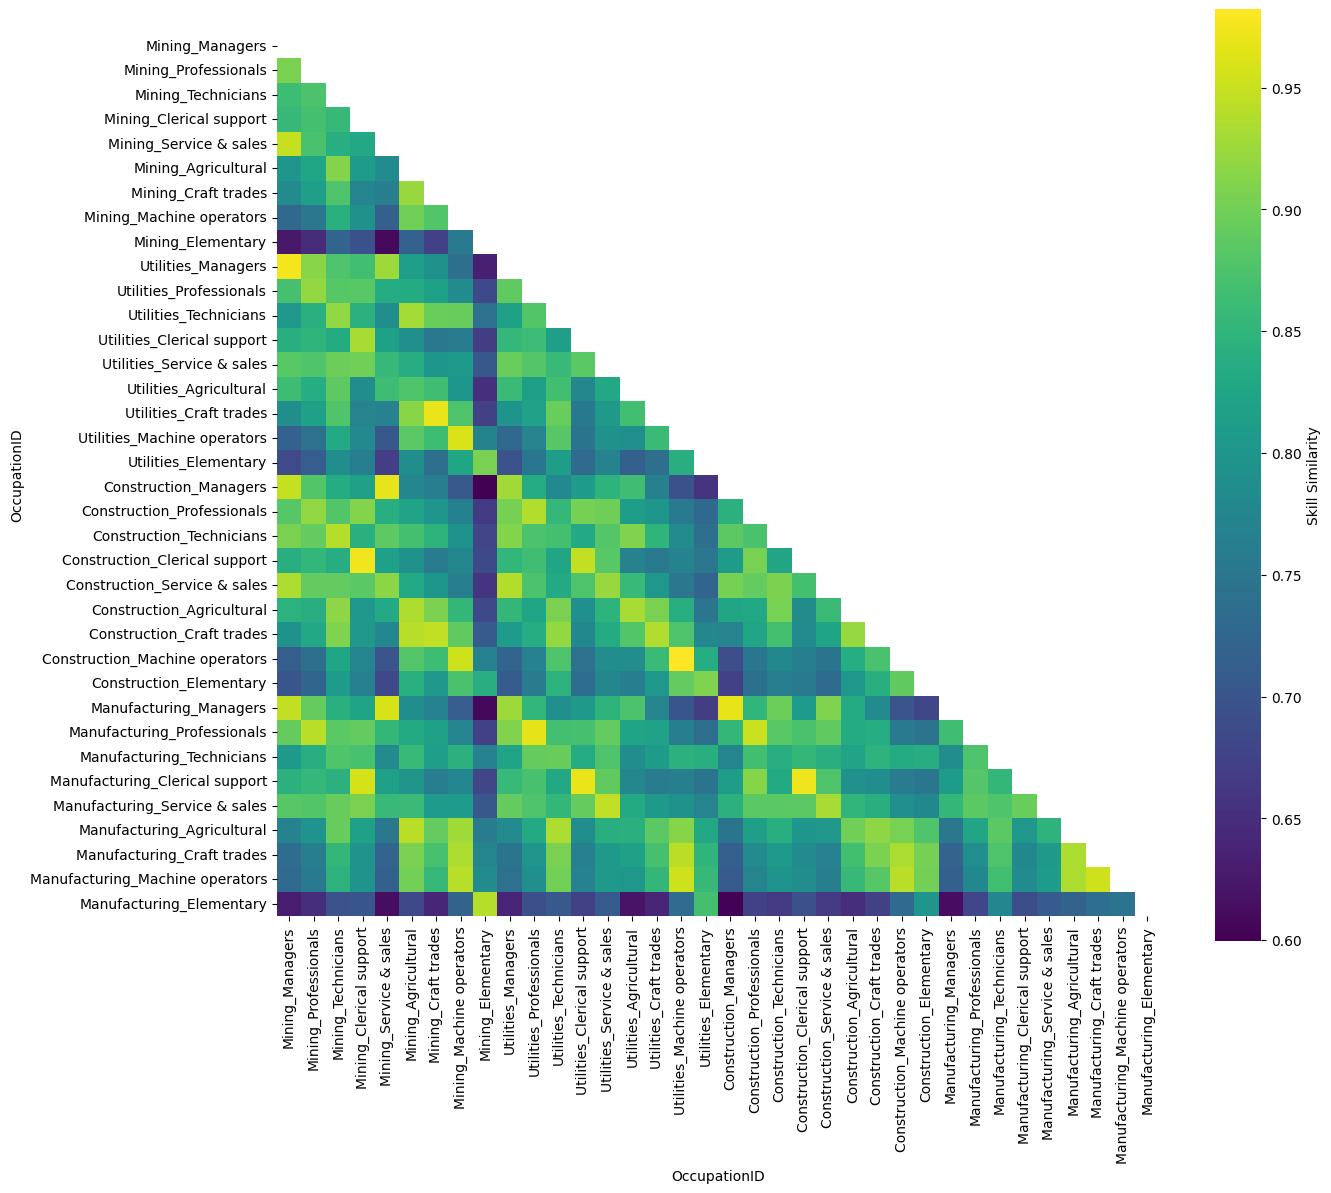

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_excel("final_skill_importance.xlsx")

# 构建全体职业技能矩阵，行是 (NAICS, ISCO-main)
df['OccupationID'] = df['NAICS'].astype(str) + "_" + df['ISCO-main'].astype(str)

df.set_index('OccupationID', inplace=True)  # 非必须，但规范

pivot_df = df.pivot_table(
    index='OccupationID',
    columns='Element Name',
    values='final_skill_importance',
    aggfunc='mean'
).fillna(0)

# 获取职业编码
isco_codes = pivot_df.index
similarity_matrix = pd.DataFrame(index=isco_codes, columns=isco_codes, dtype=float)

# 计算任意两个职业之间的技能相似度
for i in isco_codes:
    for j in isco_codes:
        vec_i = pivot_df.loc[i]
        vec_j = pivot_df.loc[j]
        min_sum = np.minimum(vec_i, vec_j).sum()
        max_sum = np.maximum(vec_i, vec_j).sum()
        similarity_matrix.loc[i, j] = min_sum / max_sum if max_sum != 0 else 0.0

# 显示完整职业相似度矩阵
similarity_matrix

similarity_matrix.to_excel("similarity_matrix.xlsx", index=False)

# 定义映射字典
naics_mapping = {
    "21": "Mining",
    "22": "Utilities",
    "23": "Construction",
    "31": "Manufacturing", "32": "Manufacturing", "33": "Manufacturing"
}

isco_mapping = {
    "1": "Managers",
    "2": "Professionals",
    "3": "Technicians",
    "4": "Clerical support",
    "5": "Service & sales",
    "6": "Agricultural",
    "7": "Craft trades",
    "8": "Machine operators",
    "9": "Elementary"
}

# 生成标签（行业_职业）
def label(row_id):
    naics, isco = row_id.split("_")
    naics_label = naics_mapping.get(naics[:2], naics)
    isco_label = isco_mapping.get(isco, isco)
    return f"{naics_label}_{isco_label}"

labels = [label(rid) for rid in similarity_matrix.index]

# 设置遮罩（上三角不画）
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

# 画热力图
plt.figure(figsize=(14, 12))

sns.heatmap(similarity_matrix, 
            cmap="viridis", 
            mask=mask, 
            xticklabels=labels, 
            yticklabels=labels,
            cbar_kws={"label": "Skill Similarity"},
            square=True)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("Skill Similarity.png", dpi=300, bbox_inches="tight")
plt.show()


In [11]:
# Re-import required libraries after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ISCO 职业名称映射
isco_mapping = {
    "Managers": "1",
    "Professionals": "2",
    "Technicians & associat": "3",
    "Clerical support worke": "4",
    "Service & sales worker": "5",
    "Skilled agricultural": "6",
    "Craft and related trad": "7",
    "Plant  machine operato": "8",
    "Elementary occupations": "9"
}

# NAICS 字母前缀 → NAICS 行业编号映射
naics_mapping = {
    "B": "21",       # Mining
    "C": "31-33",       # Manufacturing (31-33 合并为 31)
    "D": "22",       # Utilities
    "F": "23"        # Construction
}

# 技能相似度阈值序列
thresholds = np.arange(0.6, 1.01, 0.05)

employment_df_EU = pd.read_excel("详细职业.xlsx",sheet_name="China")
similarity_df = pd.read_excel("similarity_matrix.xlsx",index_col=None)

employment_df_EU["OccupationID"] = employment_df_EU["time"].apply(parse_occupation_id)
print(employment_df_EU["time"])
def parse_occupation_id(label: str) -> str:
    """从类似 'baseline5; sum of RTI; B-Professionals' 中提取 OccupationID"""
    try:
        part = label.split(";")[-1].strip()  # B-Professionals
        naics_code, occupation_name = part.split("-", 1)
        naics = naics_mapping.get(naics_code.strip(), "UNKNOWN")
        isco = isco_mapping.get(occupation_name.strip(), "UNKNOWN")
        return f"{naics}_{isco}"
    except:
        return "UNKNOWN_UNKNOWN"

print(employment_df_EU["OccupationID"])

0                  baseline5; 41 China (CN); B-Managers
1             baseline5; 41 China (CN); B-Professionals
2     baseline5; 41 China (CN); B-Technicians & asso...
3     baseline5; 41 China (CN); B-Clerical support w...
4     baseline5; 41 China (CN); B-Service & sales wo...
5      baseline5; 41 China (CN); B-Skilled agricultural
6     baseline5; 41 China (CN); B-Craft and related ...
7     baseline5; 41 China (CN); B-Plant  machine ope...
8     baseline5; 41 China (CN); B-Elementary occupat...
9                  baseline5; 41 China (CN); C-Managers
10            baseline5; 41 China (CN); C-Professionals
11    baseline5; 41 China (CN); C-Technicians & asso...
12    baseline5; 41 China (CN); C-Clerical support w...
13    baseline5; 41 China (CN); C-Service & sales wo...
14     baseline5; 41 China (CN); C-Skilled agricultural
15    baseline5; 41 China (CN); C-Craft and related ...
16    baseline5; 41 China (CN); C-Plant  machine ope...
17    baseline5; 41 China (CN); C-Elementary occ

In [57]:

employment = employment_df_EU[["time", 2030]].copy()
employment[2030] = -employment[2030]
year=2030
thresholds = np.arange(0.9, 1, 0.1)

    # 解析 OccupationID
employment["OccupationID"] = employment["time"].apply(parse_occupation_id)
  
    # 分类岗位变化
demand = employment[employment[year] > 0].set_index("OccupationID")[year]
supply = employment[employment[year] < 0].set_index("OccupationID")[year].abs()

results = {"threshold": [], "filled_positions": [], "unfilled_positions": [],"untransferred_supply": []}



similarity_df = pd.read_excel("similarity_matrix.xlsx", index_col=0)

# 确保索引和列名都是字符串类型
similarity_df.index = similarity_df.index.astype(str)
similarity_df.columns = similarity_df.columns.astype(str)


for t in thresholds:
    remaining_supply = supply.copy()
    print(remaining_supply)

    remaining_demand = demand.copy()
    total_filled = 0
    print(t)

    for d_job, d_count in remaining_demand.items():
        if d_job not in similarity_df.columns:
            continue
        similar_jobs = similarity_df[d_job][similarity_df[d_job] >= t].index.intersection(remaining_supply.index)
        print(d_job)
        print(similar_jobs)

        for s_job in similar_jobs:
            transferable = min(d_count, remaining_supply[s_job])
            total_filled += transferable
            d_count -= transferable
            remaining_supply[s_job] -= transferable
            if d_count <= 0:
                break
    print(remaining_supply)






OccupationID
21_1     386.5583
21_2    1314.4878
21_3     873.3372
21_4     699.7162
21_7     645.6852
21_8    1635.5327
21_9     345.4366
Name: 2030, dtype: float64
0.9
31-33_1
Index(['21_1'], dtype='object')
31-33_2
Index(['21_2'], dtype='object')
31-33_3
Index([], dtype='object')
31-33_4
Index(['21_4'], dtype='object')
31-33_5
Index(['21_4'], dtype='object')
31-33_6
Index(['21_8'], dtype='object')
31-33_7
Index(['21_8'], dtype='object')
31-33_8
Index(['21_8'], dtype='object')
31-33_9
Index(['21_9'], dtype='object')
22_1
Index(['21_1', '21_2'], dtype='object')
22_2
Index(['21_2'], dtype='object')
22_3
Index(['21_3'], dtype='object')
22_4
Index(['21_4'], dtype='object')
22_5
Index([], dtype='object')
22_7
Index(['21_7'], dtype='object')
22_8
Index(['21_8'], dtype='object')
22_9
Index(['21_9'], dtype='object')
23_1
Index(['21_1'], dtype='object')
23_2
Index(['21_2', '21_4'], dtype='object')
23_3
Index(['21_1', '21_3'], dtype='object')
23_4
Index(['21_4'], dtype='object')
23_5
Index(['2

In [38]:
print(remaining_supply.index)

Index(['21_1', '21_2', '21_3', '21_4', '21_7', '21_8', '21_9'], dtype='object', name='OccupationID')


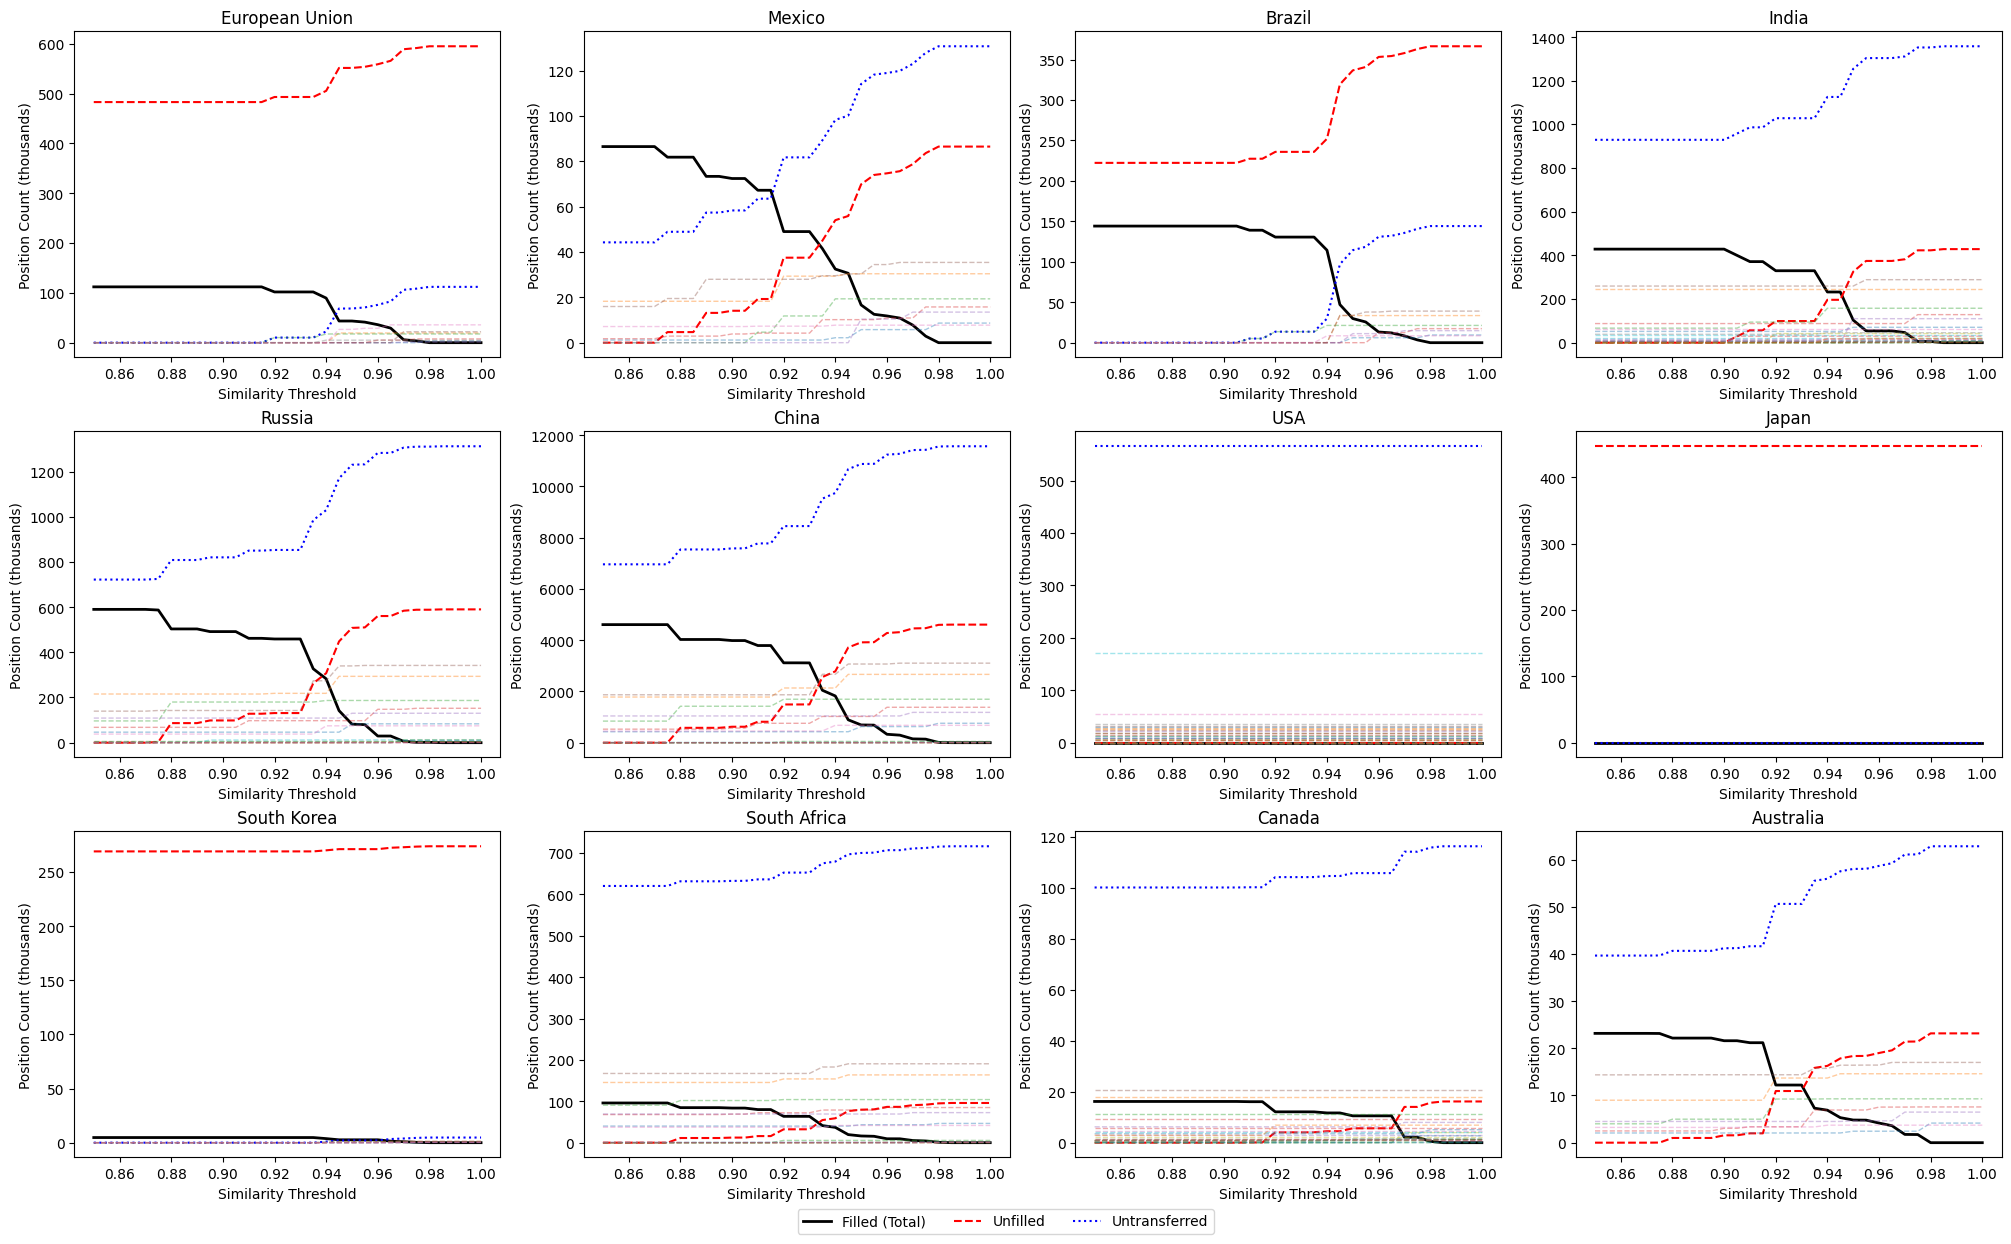

In [2]:
# Re-import required libraries after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ISCO 职业名称映射
isco_mapping = {
    "Managers": "1",
    "Professionals": "2",
    "Technicians & associat": "3",
    "Clerical support worke": "4",
    "Service & sales worker": "5",
    "Skilled agricultural": "6",
    "Craft and related trad": "7",
    "Plant  machine operato": "8",
    "Elementary occupations": "9"
}

# NAICS 字母前缀 → NAICS 行业编号映射
naics_mapping = {
    "B": "21",       # Mining
    "C": "31-33",       # Manufacturing (31-33 合并为 31)
    "D": "22",       # Utilities
    "F": "23"        # Construction
}

# 技能相似度阈值序列
thresholds = np.arange(0.85, 1, 0.005)


similarity_df = pd.read_excel("similarity_matrix.xlsx", index_col=0)
similarity_df.index = similarity_df.index.astype(str)
similarity_df.columns = similarity_df.columns.astype(str)


def parse_occupation_id(label: str) -> str:
    """从类似 'baseline5; sum of RTI; B-Professionals' 中提取 OccupationID"""
    try:
        part = label.split(";")[-1].strip()  # B-Professionals
        naics_code, occupation_name = part.split("-", 1)
        naics = naics_mapping.get(naics_code.strip(), "UNKNOWN")
        isco = isco_mapping.get(occupation_name.strip(), "UNKNOWN")
        return f"{naics}_{isco}"
    except:
        return "UNKNOWN_UNKNOWN"


def compute_transfer_analysis(employment_df: pd.DataFrame, similarity_df: pd.DataFrame, year: str):
    """对一个国家某年数据，计算不同技能相似度阈值下的可转移就业统计"""
    # 提取某年数据并修正正负（增减反了）
    employment = employment_df[["time", year]].copy()
    employment[year] = -employment[year]

    # 解析 OccupationID
    employment["OccupationID"] = employment["time"].apply(parse_occupation_id)

    # 分类岗位变化
    demand = employment[employment[year] > 0].set_index("OccupationID")[year]
    supply = employment[employment[year] < 0].set_index("OccupationID")[year].abs()

    results = {"threshold": [], "filled_positions": [], "unfilled_positions": [],"untransferred_supply": []}
    supply_snapshots = {}
    


    for t in thresholds:
        remaining_supply = supply.copy()
        remaining_demand = demand.copy()
        total_filled = 0
        candidates = []

        for d_job, d_count in remaining_demand.items():
            for s_job, s_count in supply.items():
                if s_job in similarity_df.index and d_job in similarity_df.columns:
                      score = similarity_df.at[s_job, d_job]
                      if score >= t:
                          candidates.append((score, d_job, s_job))
        candidates.sort(reverse=True)

        for score, d_job, s_job in candidates:
            if remaining_demand[d_job] == 0 or remaining_supply[s_job] == 0:
                continue
            transferable = min(remaining_demand[d_job], remaining_supply[s_job])
            remaining_demand[d_job] -= transferable
            remaining_supply[s_job] -= transferable
            total_filled += transferable
                         

        results["threshold"].append(t)
        results["filled_positions"].append(total_filled)
        results["unfilled_positions"].append(demand.sum() - total_filled)
        results["untransferred_supply"].append(remaining_supply.sum()) 
        supply_snapshots[t] = remaining_supply.copy()
    summary_df = pd.DataFrame(results)
    return summary_df, supply_snapshots


def plot_transfer_subplot(summary_df, supply_snapshots, country_name, ax):
    ax.plot(summary_df["threshold"], summary_df["filled_positions"], label="Filled (Total)", color="black", linewidth=2)
    ax.plot(summary_df["threshold"], summary_df["unfilled_positions"], label="Unfilled", linestyle="--", color="red")
    ax.plot(summary_df["threshold"], summary_df["untransferred_supply"], label="Untransferred", linestyle=":", color="blue")
    
    supply_df = pd.DataFrame(supply_snapshots)  # threshold 是列名，行是 OccupationID
    for occ_id in supply_df.index:
        ax.plot(supply_df.columns, supply_df.loc[occ_id], linestyle="--", alpha=0.4, linewidth=1)

    ax.set_title(country_name)
    ax.set_xlabel("Similarity Threshold")
    ax.set_ylabel("Position Count (thousands)")



excel_file = "详细职业.xlsx"
countries = pd.ExcelFile(excel_file).sheet_names

# 创建子图（3行4列）
fig, axes = plt.subplots(3, 4, figsize=(20, 12), constrained_layout=True)
axes = axes.flatten()

for idx, country in enumerate(countries):
    if idx >= len(axes): break
    df = pd.read_excel(excel_file, sheet_name=country)
    summary_df, supply_snapshots = compute_transfer_analysis(df, similarity_df, year=2050)
    #with pd.ExcelWriter("TransferResults_2050.xlsx") as writer:
       # for country in countries:
      #      df = pd.read_excel(excel_file, sheet_name=country)
        #    summary_df, supply_snapshots = compute_transfer_analysis(df, similarity_df, year=2050)
    
            # 写入两个 sheet：每个国家写两个 sheet（如 China_Summary 和 China_Supply）
         #   summary_df.to_excel(writer, sheet_name=f"{country}_Summary", index=False)
          #  pd.DataFrame(supply_snapshots).to_excel(writer, sheet_name=f"{country}_Supply")
    plot_transfer_subplot(summary_df, supply_snapshots, country, axes[idx])

# 添加图例 & 保存
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.03), ncol=5)

plt.savefig("all_countries_transfer_analysis2050_2.png", dpi=300,bbox_inches="tight")
plt.show()


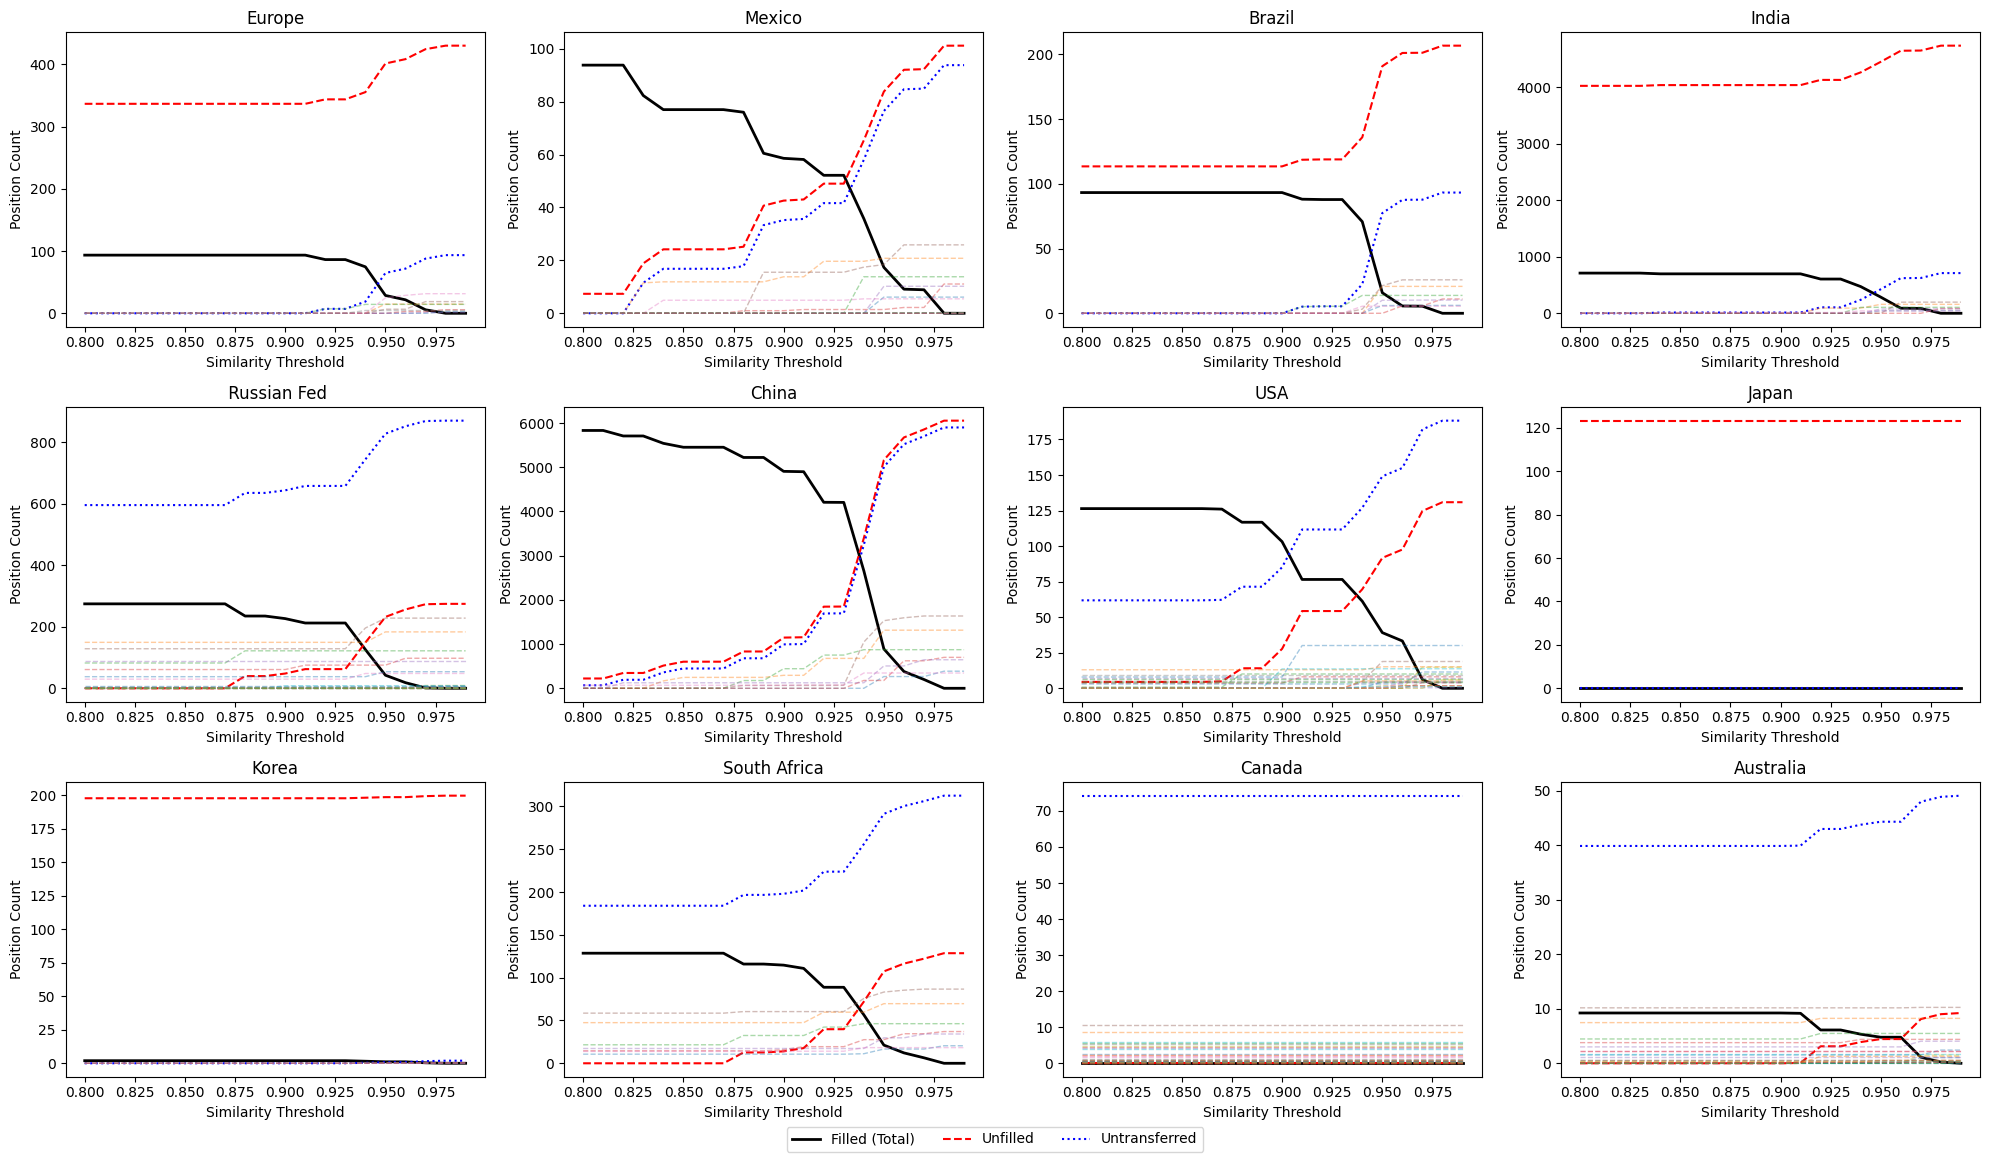

In [94]:
# Re-import required libraries after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ISCO 职业名称映射
isco_mapping = {
    "Managers": "1",
    "Professionals": "2",
    "Technicians & associat": "3",
    "Clerical support worke": "4",
    "Service & sales worker": "5",
    "Skilled agricultural": "6",
    "Craft and related trad": "7",
    "Plant  machine operato": "8",
    "Elementary occupations": "9"
}

# NAICS 字母前缀 → NAICS 行业编号映射
naics_mapping = {
    "B": "21",       # Mining
    "C": "31-33",       # Manufacturing (31-33 合并为 31)
    "D": "22",       # Utilities
    "F": "23"        # Construction
}

# 技能相似度阈值序列
thresholds = np.arange(0.8, 1, 0.01)


similarity_df = pd.read_excel("similarity_matrix.xlsx", index_col=0)
similarity_df.index = similarity_df.index.astype(str)
similarity_df.columns = similarity_df.columns.astype(str)


def parse_occupation_id(label: str) -> str:
    """从类似 'baseline5; sum of RTI; B-Professionals' 中提取 OccupationID"""
    try:
        part = label.split(";")[-1].strip()  # B-Professionals
        naics_code, occupation_name = part.split("-", 1)
        naics = naics_mapping.get(naics_code.strip(), "UNKNOWN")
        isco = isco_mapping.get(occupation_name.strip(), "UNKNOWN")
        return f"{naics}_{isco}"
    except:
        return "UNKNOWN_UNKNOWN"


def compute_transfer_analysis(employment_df: pd.DataFrame, similarity_df: pd.DataFrame, year: str):
    """对一个国家某年数据，计算不同技能相似度阈值下的可转移就业统计"""
    # 提取某年数据并修正正负（增减反了）
    employment = employment_df[["time", year]].copy()
    employment[year] = -employment[year]

    # 解析 OccupationID
    employment["OccupationID"] = employment["time"].apply(parse_occupation_id)

    # 分类岗位变化
    demand = employment[employment[year] > 0].set_index("OccupationID")[year]
    supply = employment[employment[year] < 0].set_index("OccupationID")[year].abs()

    results = {"threshold": [], "filled_positions": [], "unfilled_positions": [],"untransferred_supply": []}
    supply_snapshots = {}
    


    for t in thresholds:
        remaining_supply = supply.copy()
        remaining_demand = demand.copy()
        total_filled = 0
        candidates = []

        for d_job, d_count in remaining_demand.items():
            for s_job, s_count in supply.items():
                if s_job in similarity_df.index and d_job in similarity_df.columns:
                      score = similarity_df.at[s_job, d_job]
                      if score >= t:
                          candidates.append((score, d_job, s_job))
        candidates.sort(reverse=True)

        for score, d_job, s_job in candidates:
            if remaining_demand[d_job] == 0 or remaining_supply[s_job] == 0:
                continue
            transferable = min(remaining_demand[d_job], remaining_supply[s_job])
            remaining_demand[d_job] -= transferable
            remaining_supply[s_job] -= transferable
            total_filled += transferable
                         

        results["threshold"].append(t)
        results["filled_positions"].append(total_filled)
        results["unfilled_positions"].append(demand.sum() - total_filled)
        results["untransferred_supply"].append(remaining_supply.sum()) 
        supply_snapshots[t] = remaining_supply.copy()
    summary_df = pd.DataFrame(results)
    return summary_df, supply_snapshots


def plot_transfer_subplot(summary_df, supply_snapshots, country_name, ax):
    ax.plot(summary_df["threshold"], summary_df["filled_positions"], label="Filled (Total)", color="black", linewidth=2)
    ax.plot(summary_df["threshold"], summary_df["unfilled_positions"], label="Unfilled", linestyle="--", color="red")
    ax.plot(summary_df["threshold"], summary_df["untransferred_supply"], label="Untransferred", linestyle=":", color="blue")

    supply_df = pd.DataFrame(supply_snapshots)  # threshold 是列名，行是 OccupationID
    for occ_id in supply_df.index:
        ax.plot(supply_df.columns, supply_df.loc[occ_id], linestyle="--", alpha=0.4, linewidth=1)

    ax.set_title(country_name)
    ax.set_xlabel("Similarity Threshold")
    ax.set_ylabel("Position Count")


excel_file = "详细职业.xlsx"
countries = pd.ExcelFile(excel_file).sheet_names

# 创建子图（3行4列）
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for idx, country in enumerate(countries):
    if idx >= len(axes): break
    df = pd.read_excel(excel_file, sheet_name=country)
    summary_df, supply_snapshots = compute_transfer_analysis(df, similarity_df, year=2030)
    plot_transfer_subplot(summary_df, supply_snapshots, country, axes[idx])

# 添加图例 & 保存
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=5)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("all_countries_transfer_analysis2030.png", dpi=300)
plt.show()
